# Clustering Conformers
In this best practices notebook, we will use the [QM7 dataset](http://quantum-machine.org/datasets/) to illustrate how one can use clustering to identify different groups of molecules based on their geometric properties.

To run this notebook, you will need to use a kernel with the following libraries installed:
* RDKit
* Pandas
* ipykernel

## K-means clustering
If you are interested in the k-means clustering algorithm, you can explore the function `kmeans` implemented below. Alternatively, you can use the implementation provided by scikit-learn (`sklearn.cluster.KMeans`). We summarize the algorithm below:

**The k-means algorithm:**
1. Randomly pick k centers (or centroids) among all the data points.
2. Assign each data point to its nearest center, forming an initial set of clusters.
3. Refine the clusters: for each cluster, compute its new center as the average of all data points in the cluster.
4. Repeat steps 2 and 3 until convergence; convergence is achieved when the assignments no longer change, i.e., the new cluster centers are the same as the previous ones.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans(data, k):
    """
    Perform K-means clustering on a given dataset.

    Args:
        data (numpy.ndarray): The input data array with shape (number of patterns, number of features).
        k (int): The number of clusters to form.

    Returns:
        numpy.ndarray: The resulting labels of each pattern, indicating the cluster it belongs to.
        int: The number of iterations taken to converge.
    """
    from scipy.spatial import distance_matrix

    npatt, nfeat = data.shape

    # 1. Randomly pick k centers (centroids)
    centroids = np.zeros((k, nfeat))
    inds = np.random.choice(npatt, k, replace=False)
    for i in range(k):
        centroids[i, :] = data[inds[i], :]

    # 2. Assign each point to its nearest center
    distances = distance_matrix(data, centroids)
    z = np.zeros(npatt) # Initialize cluster assignments
    zold = np.zeros(npatt) # Track previous cluster assignments
    z = np.argmin(distances, axis=1) # Assign clusters based on minimum distance

    icount = 0
    while np.any(np.not_equal(z, zold)):
        zold = z.copy()
        # 3. Update the k cluster centroids based on the assigned cluster membership
        for i in range(k):
            inds = np.where(z == i)
            centroids[i, :] = np.mean(data[inds], axis=1)

        # Recompute distances and reassign clusters
        distances = distance_matrix(data, centroids)
        z = np.argmin(distances, axis=1)
        icount += 1

    return z, icount

## Walk-through example: distinguishing different groups of conformers
For this example, we will use the QM7 dataset. 

Below, we will perform clustering on the geometric properties of the different molecules, and on the atomic numbers of their atoms. 

We will use the independent elements of the (symmetric) Coulomb matrix.

In [2]:
import scipy.io

# Import the QM7 dataset
dataset = scipy.io.loadmat('../data/qm7.mat')

# Count how many C and O atoms there are in each molecule
n_C_atoms = np.count_nonzero(dataset['Z'] == 6, axis=1)
n_O_atoms = np.count_nonzero(dataset['Z'] == 8, axis=1)

Before clustering, let's create subsets of molecules with specific numbers of atoms. 

Then, for each set of molecules with same number of atoms, we will perform clustering. 

Lastly, we will evaluate the goodness of the clustering by looking at the atomization energies.

The numbers of atoms in the QM7 molecules range from 4 to 23.


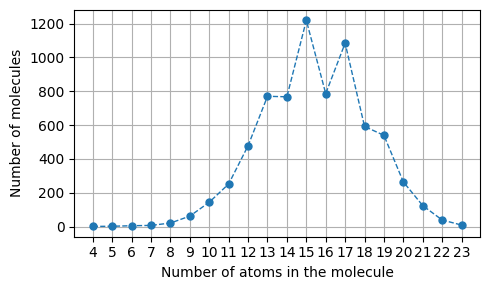

In [3]:
nonzeros = np.count_nonzero(dataset['Z'], axis=1)
print('The numbers of atoms in the QM7 molecules range from %s to %s.' % (np.min(nonzeros), np.max(nonzeros)))

lengths = []
for n_atoms in range(np.min(nonzeros), np.max(nonzeros)+1):
    lengths.append(len(dataset['Z'][np.where(nonzeros == n_atoms)]))

# Plot the distribution in numbers of atoms
plt.figure(figsize=(5,3))

plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 10

plt.plot(np.arange(np.min(nonzeros), np.max(nonzeros)+1), lengths, '.', linestyle='--')
plt.xticks(np.arange(np.min(nonzeros),np.max(nonzeros)+1))
#plt.yscale('log')

plt.ylabel('Number of molecules')
plt.xlabel('Number of atoms in the molecule')

plt.grid()
plt.tight_layout()

plt.show()

Let's select molecules with 15 atoms:

In [4]:
n_atoms = 15

energies = dataset['T'][0][np.where(nonzeros == n_atoms)]
coulomb_matrices = dataset['X'][np.where(nonzeros == n_atoms)]

coulomb = []  # For storing flattened CMs
diagonal = []  # For storing the sum of the CM diagonals

for i_mol in range(len(coulomb_matrices)):
    coulomb.append([])
    # Flatten the CMs and store them
    for i in range(n_atoms):
        for j in range(i+1):
            coulomb[i_mol].append(coulomb_matrices[i_mol, i, j])
    diagonal.append(np.sum(np.diag(coulomb_matrices[i_mol])))

coulomb = np.array(coulomb)
print(coulomb.shape)

(1219, 120)


The k-means algorithm requires us to preliminarly fix the number of clusters; usually, this information is a desired result of the clustering procedure, so we will proceed as in the [Clustering Trajectories](./Clustering-Trajectories.ipynb) notebook by evaluating the silhouette score for different numbers of clusters to identify the 'best' number of clusters to use.

In [5]:
# Here you can use the above k-means algorithm...
# z_kmeans, icount = kmeans(coulomb,n_clusters)  # Uncomment this line

# ...or simply the sci-kit learn implementation below
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores_kmeans = []
labels_kmeans = []
ks_kmeans = np.arange(2,21)

# Compute the silhouette score for a range of clusters, from k=2 to k=21
for n_clusters in ks_kmeans:
    clustering = KMeans(n_clusters).fit(coulomb)
    labels_kmeans.append(clustering.labels_)
    scores_kmeans.append(silhouette_score(coulomb, labels_kmeans[-1]))

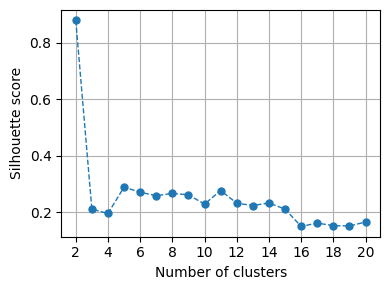

In [6]:
# Plot the silhouette score as a function of the number of clusters
plt.figure(figsize=(4,3))

plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 10

plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')
plt.plot(ks_kmeans,scores_kmeans, '.', linestyle='--')
plt.xticks(ks_kmeans[::2])

plt.grid()
plt.tight_layout()

plt.show()

The above plot suggests that we might want to select k=2 to cluster this data, as k=2 maximizes the silhouette score.

Alternatively, we can use the DBSCAN algorithm, which does not require us to fix the number of clusters. However, we do need to tune the parameter $\varepsilon$. Below we will compare the results provided by the two methods.

Unclassified patterns are marked by -1, so we can evaluate the goodness of the clustering by looking at the resulting labels.

In [7]:
from sklearn.cluster import DBSCAN

scores_DBSCAN = []
labels_DBSCAN = []
ks_DBSCAN = []

# Values of epsilon to try
epss = np.arange(5,85,5)

# Predict the labels (membership in an identified cluster) for various values of epsilon using DBSCAN
for eps in epss:
    clustering = DBSCAN(eps=eps, min_samples=3).fit(coulomb)
    labels_DBSCAN.append(clustering.labels_)
    scores_DBSCAN.append(silhouette_score(coulomb, labels_DBSCAN[-1]))
    ks_DBSCAN.append(np.max(labels_DBSCAN[-1]))

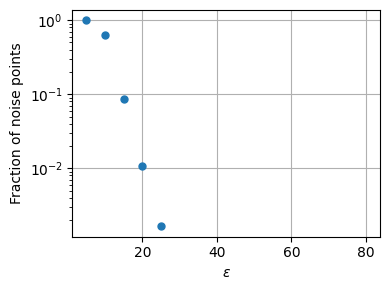

In [8]:
# Count the number of 'noise' points, which is the number of points that DBSCAN
# did not assign to any cluster
noises = []
for i in range(len(labels_DBSCAN)):
    noises.append(np.count_nonzero(labels_DBSCAN[i] == -1))

# Plot the fraction of unclassified (noise) to classified points as a function of epsilon
plt.figure(figsize=(4,3))
plt.plot(epss, np.array(noises)/len(labels_DBSCAN[i]), '.')
plt.yscale('log')
plt.ylabel('Fraction of noise points')
plt.xlabel(r'$\epsilon$')

plt.grid()
plt.tight_layout()

plt.show()

💡 A good value of epsilon depends a lot on the specific application, so it is important that you understand your dataset. To be robust to outliers, you want a low-enough value of epsilon, but not too low that all points are classified as outliers (noise).

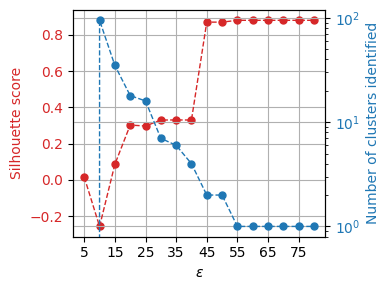

In [9]:
# Plot the DBSCAN silhouette score and number of clusters identified versus epsilon
fig, ax1 = plt.subplots(figsize=(4,3))

plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 10

color = 'tab:red'
ax1.set_xlabel(r"$\epsilon$")
ax1.set_ylabel('Silhouette score', color=color)
ax1.plot(epss, scores_DBSCAN, '.--', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(epss[::2])
plt.grid()

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Number of clusters identified', color=color)
ax2.plot(epss, ks_DBSCAN, '.--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')
plt.grid()

fig.tight_layout()

plt.show()

Above, we can see how at large values of epsilon ($\varepsilon$>55), all points are classified into one cluster. Lower values of epsilon lead to more clusters identified, until datapoints are classified into very fine-grained clusters ($\varepsilon$=10), and then into no clusters at all ($\varepsilon$=5; all points classified as noise).

From this plot, we might draw the conclusion that an optimal value of epsilon is $\varepsilon$=45 or $\varepsilon$=50, as those values maximize the silhouette score while still classifying molecules into more than one cluster (two clusters).

### Results
Let's compare now how k-means clustering compares to DBSCAN using the optimal settings we found above for each method.

coordinates for the 2d plot: sum of the off-diagonal elements of coulomb matrix (resuming the employed information) and atomization energy (new information)

In [10]:
# Sum the off-diagonal elements of the Coulomb matrices (CMs)
sum_coulomb = np.sum(coulomb, axis=1)

The results for k-means using k = 2 on our dataset are as follows:

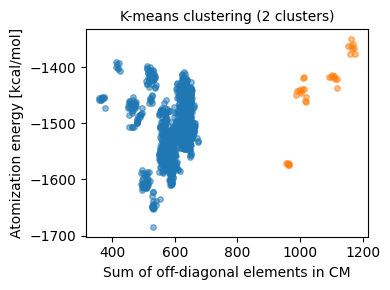

In [18]:
# Plot the results of k-means clustering with k=2
k = 2
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linewidth'] = 0.5

plt.figure(figsize=(4, 3))
plt.title('K-means clustering (%s clusters)' % (np.max(labels)+1), size=10)
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.', label=i, alpha=0.5)

plt.xlabel('Sum of off-diagonal elements in CM')
plt.ylabel('Atomization energy [kcal/mol]')
plt.tight_layout()

Below, let's compare what we would observe using different parameters for comparing the results of the two algorithms. We will compare:
 * k-means with k=8
 * DBSCAN with epsilon=20

These parameters were chosen as they lead to similar silhouette scores in both algorithms.

Silhouette score: 0.266977


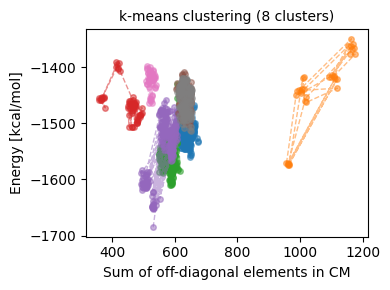

In [20]:
# Plot the results of k-means clustering with k=8
k = 8
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]
print('Silhouette score:', scores_kmeans[index])

plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linewidth'] = 1

plt.figure(figsize=(4,3))
plt.title('k-means clustering (%s clusters)' % (np.max(labels)+1), size=10)
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.--', label=i, alpha=0.5)

plt.xlabel('Sum of off-diagonal elements in CM')
plt.ylabel('Energy [kcal/mol]')
plt.tight_layout()

Silhouette score:  0.30229318


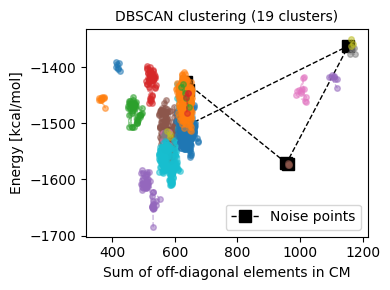

In [22]:
# Plot the results of DBSCAN with epsilon=20
epsilon = 20
index = np.where(epss == epsilon)[0][0]
labels = labels_DBSCAN[index]
print('Silhouette score: ', scores_DBSCAN[index])

plt.figure(figsize=(4,3))
plt.title('DBSCAN clustering (%s clusters)' % (np.max(labels)+1), size=10)
plt.plot(sum_coulomb[labels == -1], energies[labels == -1], 's--k', label='Noise points')
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.--', alpha=0.5)

plt.xlabel('Sum of off-diagonal elements in CM')
plt.ylabel('Energy [kcal/mol]')
plt.legend(loc='lower right')
plt.tight_layout()

Now, what do we get with k-means clustering if we fix k=19, the same number of clusters as DBSCAN above:

Silhouette score:  0.15184991


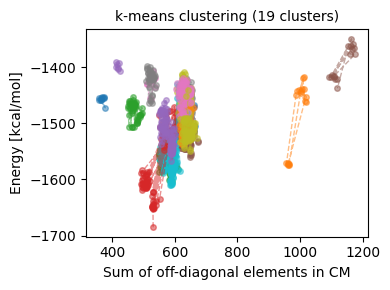

In [26]:
# Plot the results of k-means clustering with k=19
k = 19
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]
print('Silhouette score: ', scores_kmeans[index])

plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linewidth'] = 1

plt.figure(figsize=(4,3))
plt.title('k-means clustering (%s clusters)' % (np.max(labels)+1), size=10)
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.--', label=i, alpha=0.5)

plt.xlabel('Sum of off-diagonal elements in CM')
plt.ylabel('Energy [kcal/mol]')
plt.tight_layout()

Despite there being the same number of clusters, it should be evident that the two algorithms are clustering the molecules differently.

Let's analyze how many molecules can be found in each cluster for both k-means and DBSCAN with the settings resulting in similar silhouette scores:
 * k-means with k=8
 * DBSCAN with epsilon=20

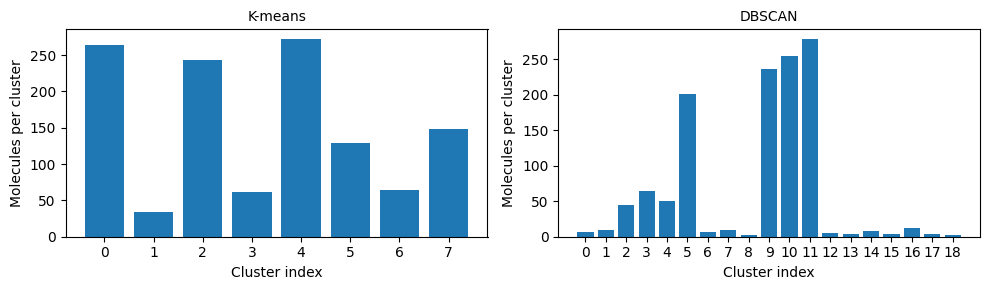

In [15]:
k = 8 # k-means
epsilon = 20 # DBSCAN

plt.figure(figsize = (10,3))

# K-means clustering
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

lengths_kmeans = []

for i_cluster in range(np.max(labels) + 1):
    lengths_kmeans.append(len(labels[labels == i_cluster]))

plt.subplot(1,2,1)
plt.bar(np.arange(np.max(labels)+1), lengths_kmeans, label='k-means', alpha=1)
plt.title('K-means', size=10)
plt.xlabel('Cluster index', size=10)
plt.ylabel('Molecules per cluster', size=10)
plt.xticks(np.arange(np.max(labels) + 1))


# DBSCAN clustering
index = np.where(epss == epsilon)[0][0]
labels = labels_DBSCAN[index]

lengths_DBscan = []
for i_cluster in range(-1, np.max(labels) + 1):
    lengths_DBscan.append(len(labels[labels == i_cluster]))

plt.subplot(1,2,2)
plt.bar(np.arange(np.max(labels) + 1), np.array(lengths_DBscan[1:]), label='DBSCAN', alpha=1)
plt.title('DBSCAN', size=10)
plt.xlabel('Cluster index', size=10)
plt.ylabel('Molecules per cluster', size=10)
plt.xticks(np.arange(np.max(labels) + 1))

plt.tight_layout()

plt.show()

As we can see, when using $\varepsilon$=20, DBSCAN clusters the molecules in QM7 into 19 clusters using their CM descriptors. However, only a few of the clusters have a significant number of molecules in them; most of the clusters are nearly empty or have just a few molecules in them.

Let's see how the atomization energy of molecules in the various clusters is distributed for the following models:
 * k-means with k=8
 * DBSCAN with epsilon=20
 * k-means with k=19

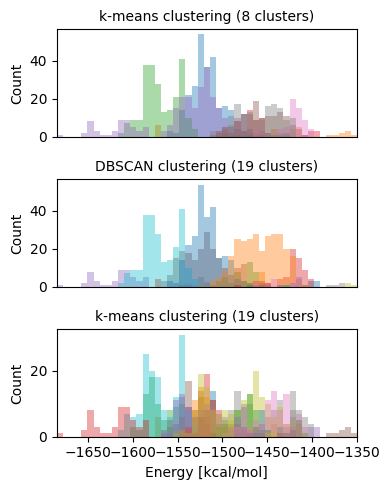

In [25]:
bins = np.linspace(np.min(energies), np.max(energies), 50)

# K-means clustering with k=8
k = 8
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

plt.figure(figsize=(4,5))

plt.subplot(3, 1, 1)
plt.title('k-means clustering (%s clusters)' % (np.max(labels) + 1), size=10)
for i in range(np.max(labels) + 1):
    plt.hist(energies[labels == i], alpha=0.4, bins=bins)  # ,density=True)
    plt.xlim([np.min(energies), np.max(energies)])
    plt.xticks([])
    plt.ylabel('Count')

# DBSCAN with epsilon=20
epsilon = 20
index = np.where(epss == epsilon)[0][0]
labels = labels_DBSCAN[index]

plt.subplot(3, 1, 2)
plt.title('DBSCAN clustering (%s clusters)' % (np.max(labels) + 1), size=10)
for i in range(np.max(labels) + 1):
    plt.hist(energies[labels == i], alpha=0.4, bins=bins)  # ,density=True)
    plt.xlim([np.min(energies), np.max(energies)])
    plt.xticks([])
    plt.ylabel('Count')

# K-means clustering with k=19
k = 19
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

plt.subplot(3,1,3)
plt.title('k-means clustering (%s clusters)' % (np.max(labels) + 1), size=10)
for i in range(np.max(labels) + 1):
    plt.hist(energies[labels == i], alpha=0.4, bins=bins)  # ,density=True)
    plt.xlim([np.min(energies), np.max(energies)])
    plt.xlabel('Energy [kcal/mol]')
    plt.ylabel('Count')

plt.tight_layout()

Despite their differences, both approaches appear able to cluster molecules in such a way that they separate into different energy ranges, with quite (surprisingly) similar results!